In [1]:
import os
import qutip as qu
from qutip import *
import numpy as np
from joblib import Parallel, delayed
from scipy.linalg import *
import os
import shutil
# from multiprocessing import Process
from pathlib import Path
from tqdm import tqdm
import pickle
import scipy as sp

import importlib
import general_functions
import sBs_noise_analysis
import plotsmodule
import yaml
import metrology_noise
import bits
import backaction_noise
importlib.reload(general_functions)
importlib.reload(sBs_noise_analysis)
importlib.reload(plotsmodule)
importlib.reload(yaml)
importlib.reload(metrology_noise)
importlib.reload(bits)
importlib.reload(backaction_noise)
from general_functions import *
from plotsmodule import *
from metrology_noise import *
from bits import *
from general_functions import * 
# from general_functions import (
#     MSD_v,
#     sBs_stabilization,
#     save_plot_data,
# )
from sBs_noise_analysis import *

In [2]:
cwd = os.getcwd()
path_QS = os.path.dirname(os.path.dirname(cwd))+ '/'
path_QS_noiseless = path_QS + 'Noiseless/'
path_QS_noiseless_data = path_QS_noiseless + 'Data/'
path_QS_noiseless_results = path_QS_noiseless_data + 'Results/'
path_QS_noise = path_QS + 'Noise/'
path_QS_noise_results = path_QS_noise + 'Results/'
path_QS_noise_results_backaction = path_QS_noise_results + 'backaction/'
path_QS_noise_results_eachnoise = path_QS_noise_results + 'eachnoise/'
path_QS_noise_results_exact = path_QS_noise_results + 'exact/'
path_QS_noise_results_states = path_QS_noise_results + 'Input_states/'
path_QS_noise_results_qorppath = path_QS_noise_results + 'q_or_p_bitstring_paths/'
path_QS_figures = path_QS + 'Figures/'
path_QS_figures_data = path_QS_figures + 'data/'

# Getting the fidelity

### checking the estimator

In [3]:
#load the data and build the estimators dictionary
name1 = 'Data - qbits - params'+str(151)
results1 = np.load(path_QS_noise_results_qorppath+name1+'.npz')
vlist1 = results1['vlist']
p_array1 = results1['p_array']
qf_array1 = results1['qf_array']
pf_array1 = results1['pf_array']

name2 = 'Data - qbits - params'+str(204)
results2 = np.load(path_QS_noise_results_qorppath+name2+'.npz')
vlist2 = results2['vlist']
p_array2 = results2['p_array']
qf_array2 = results2['qf_array']
pf_array2 = results2['pf_array']

p_array1_T = []
for i in range(len(vlist1)):
    p_array1_T.append(marginalize_probs(p_array1[i], 2)) #marginalize the probabilities to get the probabilities of each bitstring of qbits, for a given displacement q0
p_array1_T = np.array(p_array1_T)
print(vlist1/l)
stddev = 0.15 * l # should be 0.15l or 0.10l
print(p_array1_T.shape) 
print(p_array1.shape)
estimators_1 = estimators_from_parray(p_array1_T,vlist1,stddev) #estimator associated to each bitstring of qbits, for fix p0. Not ideal, but close to the ideal.
estimators_2 = estimators_from_parray(p_array2,vlist2,stddev) #estimator associated to each bitstring of qbits, for fix p0. Not ideal, but close to the ideal.
print(estimators_1/l)
print(estimators_2/l)

[-1.         -0.96610169 -0.93220339 -0.89830508 -0.86440678 -0.83050847
 -0.79661017 -0.76271186 -0.72881356 -0.69491525 -0.66101695 -0.62711864
 -0.59322034 -0.55932203 -0.52542373 -0.49152542 -0.45762712 -0.42372881
 -0.38983051 -0.3559322  -0.3220339  -0.28813559 -0.25423729 -0.22033898
 -0.18644068 -0.15254237 -0.11864407 -0.08474576 -0.05084746 -0.01694915
  0.01694915  0.05084746  0.08474576  0.11864407  0.15254237  0.18644068
  0.22033898  0.25423729  0.28813559  0.3220339   0.3559322   0.38983051
  0.42372881  0.45762712  0.49152542  0.52542373  0.55932203  0.59322034
  0.62711864  0.66101695  0.69491525  0.72881356  0.76271186  0.79661017
  0.83050847  0.86440678  0.89830508  0.93220339  0.96610169  1.        ]
(60, 4)
(60, 256)
[ 0.11650467  0.00773555 -0.00776296 -0.11652168]
[ 0.11650467  0.00773555 -0.00776296 -0.11652168]


### defining system dict

In [4]:
def load_system_dict(idx, param_path):
    param_filename = "params{}.yaml".format(idx)
    params = params = yaml.safe_load(Path(param_path + param_filename).read_text())
    delta = params["state_params"]["delta"]
    l = np.sqrt(2 * np.pi)
    t_cd_B = params["simulations"]["t_CD_B"]

    N_c = params["dimensions"]["cavity"]
    N_q = params["dimensions"]["qubit"]
    qubit_T1 = params["decays"]["qubit_T1"]
    qubit_T2 = params["decays"]["qubit_T2"]
    cavity_T1 = params["decays"]["cavity_T1"]
    cavity_T2 = params["decays"]["cavity_T2"]

    T_1q = round(qubit_T1/ t_cd_B, 5)
    T_2q = round(qubit_T2/ t_cd_B, 5)
    T_1c = round(cavity_T1/ t_cd_B, 5)
    T_2c = round(cavity_T2/ t_cd_B, 5)

    T_qphi = 1 / (1 / T_2q - 1 / (2 * T_1q))
    T_cphi = 1 / (1 / T_2c - 1 / (2 * T_1c))


    init_state_dict = np.load(
                    "../Results/Input_states/coherent_sensor_state_delta_{}-Nc{}-{}.npz".format(int(100 * delta), N_c, params["decays"]["ratio"])
                )
    init_state = init_state_dict['rho_f_array'][0]

    c_ops = [
            qu.tensor(qu.sigmam(), qu.qeye(N_c)) / np.sqrt(T_1q),
            qu.tensor(qu.qeye(N_q), qu.destroy(N_c)) / np.sqrt(T_1c),
            # qu.tensor(qu.qeye(N_q) - qu.sigmaz(), qu.qeye(N_c)) / np.sqrt(2 * T_qphi),
            qu.tensor(qu.sigmaz(), qu.qeye(N_c)) / np.sqrt(2 * T_qphi),
            qu.tensor(qu.qeye(N_q), np.sqrt(2) * qu.destroy(N_c).dag() * qu.destroy(N_c)) / np.sqrt(T_cphi),
        ]

    system_dict = {
        "dimensions": {"qubit": N_q, "cavity": N_c,},
        "operators": {
            "qubit": {
                "sx": qu.sigmax(),
                "sy": qu.sigmay(),
                "sz": qu.sigmaz(),
                "sm": qu.sigmam(),
            },
            "cavity": {"a": qu.destroy(N_c)},
        },
        "state_params": {"l": l, "delta": delta},
        "timings": {"t_B": np.linspace(0, 1.0, 51),},
        "c_ops": c_ops,
        "simulations": {
            "r": params['simulations']['r'],
            "sensor": qu.Qobj(init_state),
            'p_0': l * params['simulations']['p_0'],
            'T': params['simulations']['T'],
            'M': params['simulations']['M'],
            'N': params['simulations']['N'],
            'stddev': params['simulations']['stddev'],
        },
        "data": {
            "idx_data_q":151,
            "idx_data_p": 152,
            "path_data": path_QS_noise_results_qorppath
        },
    }
    return system_dict, params

### running

In [ ]:
#backaction, starting at 20. 
#20-26, T in 2 to 8, T+M = 12, Delta =0.3, 1.0 yale, fidelity, no recovery 
#27-33, T in 2 to 8, T+M = 12, Delta =0.3, 1.0 yale, fidelity, with simple recovery
#34 and 35 for performance
#36-42, T in 2 to 8, T+M = 12, Delta = 0.3, 1.0 yale, fidelity, with simple recovery, qrange 0 to 0.45l, 40 steps. 


#q_or_p_bitstring_paths
#151-152, delta = 0.3, 1.0 yale, 8 rounds, p0=0, q0=0 #use these results for backaction evading inputs
#264-267, delta = 0.3, 1.0 yale, 1,2,4,8 rounds, q0=0 
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0


index_range = list(np.arange(25,27)) 
delta = 0.3
recovery_yes_range = np.arange(36, 43)
recovery_no_range = np.arange(20, 27)

for idx in tqdm(index_range):
    system_dict, params = load_system_dict(idx, path_sbs_noise_params_backaction)
    if idx in recovery_yes_range:
        system_dict['recovery'] = 'yes'
        print("Recovery is on for idx {}".format(idx))
    elif idx in recovery_no_range:
        system_dict['recovery'] = 'no'
        print("Recovery is off for idx {}".format(idx))
    fidelities, probabilities, bitstrings, traces, purities = backaction_evading_sBs_fidelities_probs_allqbits_simplerecovery_parallel(system_dict,params)

    dict_save = {}
    dict_save['fidelities'] = fidelities
    dict_save['probabilities'] = probabilities
    dict_save['bitstrings'] = bitstrings
    dict_save['traces'] = traces
    dict_save['purities'] = purities
    name = 'Data - params{}.npz'.format(idx)
    np.savez(path_QS_noise_results_backaction + name, **dict_save)


  0%|          | 0/2 [00:00<?, ?it/s]

Recovery is off for idx 25


 50%|█████     | 1/2 [2:48:06<2:48:06, 10086.32s/it]

Recovery is off for idx 26


# Running backaction

## system dict

In [ ]:
def load_system_dict(idx, param_path):
    param_filename = "params{}.yaml".format(idx)
    params = params = yaml.safe_load(Path(param_path + param_filename).read_text())
    delta = params["state_params"]["delta"]
    l = np.sqrt(2 * np.pi)
    t_cd_B = params["simulations"]["t_CD_B"]

    N_c = params["dimensions"]["cavity"]
    N_q = params["dimensions"]["qubit"]
    qubit_T1 = params["decays"]["qubit_T1"]
    qubit_T2 = params["decays"]["qubit_T2"]
    cavity_T1 = params["decays"]["cavity_T1"]
    cavity_T2 = params["decays"]["cavity_T2"]

    T_1q = round(qubit_T1/ t_cd_B, 5)
    T_2q = round(qubit_T2/ t_cd_B, 5)
    T_1c = round(cavity_T1/ t_cd_B, 5)
    T_2c = round(cavity_T2/ t_cd_B, 5)

    T_qphi = 1 / (1 / T_2q - 1 / (2 * T_1q))
    T_cphi = 1 / (1 / T_2c - 1 / (2 * T_1c))


    init_state_dict = np.load(
                    "../Results/Input_states/coherent_sensor_state_delta_{}-Nc{}-{}.npz".format(int(100 * delta), N_c, params["decays"]["ratio"])
                )
    init_state = init_state_dict['rho_f_array'][0]

    c_ops = [
            qu.tensor(qu.sigmam(), qu.qeye(N_c)) / np.sqrt(T_1q),
            qu.tensor(qu.qeye(N_q), qu.destroy(N_c)) / np.sqrt(T_1c),
            # qu.tensor(qu.qeye(N_q) - qu.sigmaz(), qu.qeye(N_c)) / np.sqrt(2 * T_qphi),
            qu.tensor(qu.sigmaz(), qu.qeye(N_c)) / np.sqrt(2 * T_qphi),
            qu.tensor(qu.qeye(N_q), np.sqrt(2) * qu.destroy(N_c).dag() * qu.destroy(N_c)) / np.sqrt(T_cphi),
        ]

    system_dict = {
        "dimensions": {"qubit": N_q, "cavity": N_c,},
        "operators": {
            "qubit": {
                "sx": qu.sigmax(),
                "sy": qu.sigmay(),
                "sz": qu.sigmaz(),
                "sm": qu.sigmam(),
            },
            "cavity": {"a": qu.destroy(N_c)},
        },
        "state_params": {"l": l, "delta": delta},
        "timings": {"t_B": np.linspace(0, 1.0, 51),},
        "c_ops": c_ops,
        "simulations": {
            "r": params['simulations']['r'],
            "sensor": qu.Qobj(init_state),
            'p_0': l * params['simulations']['p_0'],
            'T': params['simulations']['T'],
            'M': params['simulations']['M'],
            'N': params['simulations']['N'],
            'reps': params['simulations']['reps'],
            'stddev': params['simulations']['stddev'],
        },
        "data": {
            "idx_data_q":151,
            "idx_data_p": 152,
            "path_data": path_QS_noise_results_qorppath
        },
    }
    return system_dict, params

## running and saving

In [ ]:
#backaction, starting at 20. 
#20-26, T in 2 to 8, T+M = 12, Delta =0.3, 1.0 yale, fidelity, no recovery 
#27-33, T in 2 to 8, T+M = 12, Delta =0.3, 1.0 yale, fidelity, with simple recovery
#34, T = 6, T+M=12, Delta = 0.3, 1.0 yale, N = 2, reps = 4000, with simple recovery
#35, T = 6, T+M=12, Delta = 0.3, 1.0 yale, N = 10, reps = 4000, with simple recovery

#q_or_p_bitstring_paths
#151-152, delta = 0.3, 1.0 yale, 8 rounds, p0=0, q0=0 #use these results for backaction evading inputs
#264-267, delta = 0.3, 1.0 yale, 1,2,4,8 rounds, q0=0 
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0

index_range = list(np.arange(35,36)) 
delta = 0.3
for idx in index_range:
    system_dict, params = load_system_dict(idx, path_sbs_noise_params_backaction)
    
    squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s, bitstrings = backaction_evading_sBs_simplerecovery_parallel(system_dict, params)

    dict_save = {}
    dict_save['squared_errors_q'] = squared_errors_q
    dict_save['squared_errors_p'] = squared_errors_p
    dict_save['estimators_q'] = estimators_q
    dict_save['estimators_p'] = estimators_p
    dict_save['q0s'] = q0s
    dict_save['p0s'] = p0s
    dict_save['bitstrings'] = bitstrings
    name = 'Data - params{}.npz'.format(idx)
    np.savez(path_QS_noise_results_backaction + name, **dict_save)


  0%|          | 0/4000 [00:00<?, ?it/s]

  4%|▎         | 140/4000 [21:56<11:19:32, 10.56s/it]/Users/labl2714/Projects/GKP-metrology/GKP_noise/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  6%|▋         | 260/4000 [43:56<11:21:20, 10.93s/it]

# Recovery fidelity

In [6]:
#backaction, starting at 20. 
#20-26, T in 2 to 8, T+M = 12, Delta =0.3, 1.0 yale, fidelity, no recovery 
#27-33, T in 2 to 8, T+M = 12, Delta =0.3, 1.0 yale, fidelity, with simple recovery

fidelities, probabilities, bitstrings = [], [], []
index_range = np.arange(20,27)  # indices for which we have results
for idx in tqdm(index_range):
    dict_load = np.load(path_QS_noise_results_backaction + 'Data - params{}.npz'.format(idx))
    fidelities.append(dict_load['fidelities'])
    probabilities.append(dict_load['probabilities'])
    bitstrings.append(dict_load['bitstrings'])

fidelities_recovery, probabilities_recovery, bitstrings_recovery = [], [], []
index_range_recovery = np.arange(36,43)  # indices for which we have results
for idx in tqdm(index_range_recovery):
    dict_load = np.load(path_QS_noise_results_backaction + 'Data - params{}.npz'.format(idx))
    fidelities_recovery.append(dict_load['fidelities'])
    probabilities_recovery.append(dict_load['probabilities'])
    bitstrings_recovery.append(dict_load['bitstrings'])

weighted_fidelities = []
for i in range(len(fidelities)):
   fidelity = fidelities[i]
   prob = probabilities[i]
   avg_fidelity = []
   for j in range(len(fidelity)):
        avg_fidelity.append(np.sum(fidelity[j] * prob[j]))
    
   weighted_fidelities.append(avg_fidelity)
weighted_fidelities = np.array(weighted_fidelities)

weighted_fidelities_recovery = []
for i in range(len(fidelities_recovery)):
   fidelity = fidelities_recovery[i]
   prob = probabilities_recovery[i]
   avg_fidelity = []
   for j in range(len(fidelity)):
        avg_fidelity.append(np.sum(fidelity[j] * prob[j]))
    
   weighted_fidelities_recovery.append(avg_fidelity)

# print(weighted_fidelities)

100%|██████████| 7/7 [00:00<00:00, 1624.89it/s]


### plotting the fidelities

40
T: 2 avg weighted fidelity: 0.981255714332447
40
T: 3 avg weighted fidelity: 0.9806470154166813
40
T: 4 avg weighted fidelity: 0.9800377614303138
40
T: 5 avg weighted fidelity: 0.979381049540023
40
T: 6 avg weighted fidelity: 0.9786467891304398
40
T: 7 avg weighted fidelity: 0.9778127146347805
40
T: 8 avg weighted fidelity: 0.9768434435502287
T: 2 avg weighted fidelity with recovery: 0.9915773042404284
T: 3 avg weighted fidelity with recovery: 0.9919404187444765
T: 4 avg weighted fidelity with recovery: 0.9916212753699827
T: 5 avg weighted fidelity with recovery: 0.9904559595170699
T: 6 avg weighted fidelity with recovery: 0.9881173433627561
T: 7 avg weighted fidelity with recovery: 0.9841204350478538
T: 8 avg weighted fidelity with recovery: 0.9777629588430351


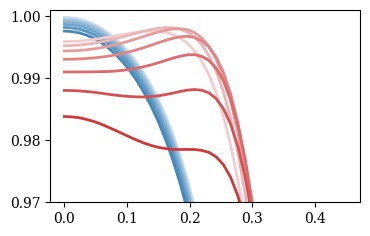

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5))

T_range = np.arange(2, 9)
qrange = np.linspace(0,0.3 * l, 20)
qrange2 = np.linspace(0,0.45 * l, 40)
index_25 = np.argmin(np.abs(qrange -.25 * l))
sigma = 0.15 * l
no_recovery_fidelities = []
prior_avg_no_recovery_fidelities = []
recovery_fidelities = []
prior_avg_recovery_fidelities = []
for i in range(len(weighted_fidelities)):
    shine = .2+.1 * i
    print(len(weighted_fidelities[i]))
    ax.plot(qrange2/l, weighted_fidelities[i], label='T+M={}'.format(i+2),color=lighten_color(blue, shine), lw=2, marker=None, markersize=4)
    prior = np.exp(-qrange2**2/(2 * sigma**2))
    prior /= np.sum(prior)
    avg_weighted_fidelity = np.sum(weighted_fidelities[i] * prior)
    no_recovery_fidelities.append(weighted_fidelities[i])
    prior_avg_no_recovery_fidelities.append(avg_weighted_fidelity)
    print("T:", i+2, "avg weighted fidelity:", avg_weighted_fidelity)

for i in range(len(weighted_fidelities_recovery)):
    shine = .2+.1 * i 
    ax.plot(qrange2/l, weighted_fidelities_recovery[i], label='T+M={}'.format(i+2), color=lighten_color(red, shine), lw=2,marker=None, markersize=4)
    prior = np.exp(-qrange2**2/(2 * sigma**2))
    prior /= np.sum(prior)
    avg_weighted_fidelity = np.sum(weighted_fidelities_recovery[i] * prior)
    recovery_fidelities.append(weighted_fidelities_recovery[i])
    prior_avg_recovery_fidelities.append(avg_weighted_fidelity)
    print("T:", i+2, "avg weighted fidelity with recovery:", avg_weighted_fidelity)

ax.set_ylim(.97,1.001)


dict_figure = {}
dict_figure['no_recovery_fidelities'] = no_recovery_fidelities
dict_figure['prior_avg_no_recovery_fidelities'] = prior_avg_no_recovery_fidelities
dict_figure['recovery_fidelities'] = recovery_fidelities
dict_figure['prior_avg_recovery_fidelities'] = prior_avg_recovery_fidelities
dict_figure['qrange'] = qrange
dict_figure['qrange2'] = qrange2
dict_figure['T_range'] = T_range
dict_figure['sigma'] = sigma
name = 'data-figure-noisy-backaction-fidelities'
np.savez(path_QS_figures_data + name, **dict_figure)

# Backaction performance

## Getting MSE different T

In [8]:
def MSE_v_onlyqorp(p_array: List, vlist: List, variance: float, r:int):
    """
    Definition of Mean Square Deviation for a given variance.
    Input:
    - vlist : list of displacement
    - variance : variance of the gaussian prior
    - system_dict : dictionary containing all the parameters defining the system.
    Return:
    - MSD : probability distribution of a gaussian prior
    - posterior_arr : posterior distribution
    """

    def p_gaussian_prior(v: List, variance: float = 1):
        p_v = (1.0 / (np.sqrt(2 * np.pi) * variance)) * np.exp(
            -(1 / (2 * variance)) * v ** 2
        )
        return p_v / sum(p_v)
    
    def p_flat_prior(v:List, variance: float=1):
        p_v = np.ones(len(v))
        return p_v / sum(p_v)

    # Definition of parameters
    ds = abs(vlist[1] - vlist[0])

    estimator_arr = np.empty((2 ** (r)))
    posterior_arr = np.empty((2 ** (r), len(vlist)))

    for idx in range(2 ** (r)):
        # probability of bitstring y
        p_y = sum(p_array[:, idx] * p_gaussian_prior(vlist, variance)) * ds #gaussian prior
        # p_y = sum(p_array[:, idx] * p_flat_prior(vlist, variance)) * ds #flat prior
        # posterior distribution
        posterior = p_array[:, idx] * p_gaussian_prior(vlist, variance) / p_y #gaussian posterior
        # posterior = p_array[:, idx] * p_flat_prior(vlist, variance) / p_y #flat posterior

        posterior_arr[idx, :] = posterior
        # estimator
        estimator_arr[idx] = ds * sum(vlist * posterior)

    MSD_v_ = np.sum(
        p_array
        * (
            np.ones((len(vlist), 2 ** (r))) * estimator_arr
            - (vlist * np.ones((2 ** (r), len(vlist)))).T
        )
        ** 2,
        axis=1,
    )
    MSD = p_gaussian_prior(vlist, variance) * np.array(MSD_v_)

    return MSD, MSD_v_, posterior_arr

100%|██████████| 101/101 [00:00<00:00, 877.57it/s]

MSD_array shape: (101,)
0.4551323691670699


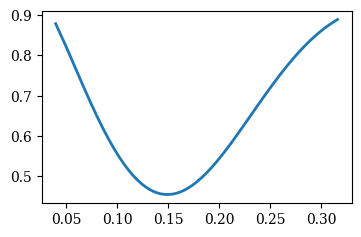

In [9]:
idx = 151
name = 'Data - qbits - params'+str(idx)
results = np.load(path_QS_noise_results_qorppath + name + '.npz')
p_array = results['p_array']
vlist = results['vlist']

T = 6
p_array_T = []
for i in range(len(vlist)):
    p_array_T.append(marginalize_probs(p_array[i], T)) #marginalize the probabilities to get the probabilities of each bitstring of qbits, for a given displacement q0
p_array_T = np.array(p_array_T)

variance_list = np.linspace(0.01, l / 4, 101)
MSD_array = np.empty((len(variance_list)))
for i in tqdm(range(len(variance_list))):
    variance = variance_list[i]
    MSD, MSD_displacement, posterior = MSE_v_onlyqorp(p_array_T, vlist, variance, T)
    MSD_array[i] = np.sum(MSD,axis=0)

print("MSD_array shape:", MSD_array.shape)
fig, ax = plt.subplots(1,1, figsize=(4,2.5))

sigma = 0.15 * l
index_sigma = np.argmin(np.abs(variance_list - sigma**2))
ax.plot(np.sqrt(variance_list)/l, MSD_array/variance_list, lw=2)
print(MSD_array[index_sigma]/variance_list[index_sigma])

## Plotting backaction performance

mean q: [0.48070363 0.46073905 0.46787163 0.46505802 0.44275253 0.4770457
 0.48133504 0.48639036 0.49810107 0.48821344]
mean p: [0.4615813  0.48389636 0.48513015 0.47473352 0.47576161 0.48297263
 0.48140348 0.47374418 0.48743171 0.50009491]


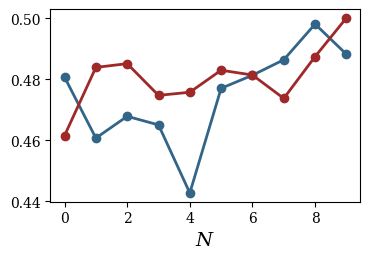

In [11]:
#35, T = 6, T+M=12, Delta = 0.3, 1.0 yale, N = 10, reps = 4000, with simple recovery

name = 'Data - params{}.npz'.format(35)
results = np.load(path_QS_noise_results_backaction + name)
squared_errors_q = results['squared_errors_q']
squared_errors_p = results['squared_errors_p']
estimators_q = results['estimators_q']
estimators_p = results['estimators_p']
q0s = results['q0s']
p0s = results['p0s']
bitstrings = results['bitstrings']

sigma = 0.15 * l

MSE_q, MSE_p = [], []
for i in range(10):
    MSE_q.append(np.mean(squared_errors_q[:,i], axis=0))
    MSE_p.append(np.mean(squared_errors_p[:,i], axis=0))
MSE_q = np.array(MSE_q)
MSE_p = np.array(MSE_p)
print("mean q:", MSE_q/sigma**2)
print("mean p:", MSE_p/sigma**2)

fig, ax = plt.subplots(1,1, figsize=(4,2.5))
ax.set_xlabel(r'$N$', fontsize=14)
ax.plot(np.arange(10), MSE_q/sigma**2, label='q', marker='o', color=blue, lw=2)
ax.plot(np.arange(10), MSE_p/sigma**2, label='p', marker='o', color=red, lw=2)

sigma = 0.15 * l
index_sigma = np.argmin(np.abs(variance_list - sigma**2))
ideal_noisy_MSE = MSD_array[index_sigma]/variance_list[index_sigma]

dict_figure = {}
dict_figure['MSE_q'] = MSE_q
dict_figure['MSE_p'] = MSE_p
dict_figure['sigma'] = sigma
dict_figure['N'] = 10
dict_figure['repeat'] = 4000
dict_figure['ideal_noisy_MSE'] = ideal_noisy_MSE 
name = 'data-figure-noisy-backaction-performance'
np.savez(path_QS_figures_data + name, **dict_figure)

# Creating yaml files

In [18]:
# for test purposes (these are q or p bitstring paths):
# 200-202, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.15l
# 203-205, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0
# 206-208, delta = 0.3, 1.0 yale, 1,2,4 rounds, p0=0.25l
# 209-211, delta = 0.3, 1.0 yale, 1,2,4 rounds, q0=0

#backaction, starting at 20. 
#20-26, T in 2 to 8, T+M = 12, Delta =0.3, 1.0 yale, fidelity, no recovery 
#34, T = 6, T+M=12, Delta = 0.3, 1.0 yale, N = 2, reps = 4000, with simple recovery
#35, T = 6, T+M=12, Delta = 0.3, 1.0 yale, N = 10, reps = 4000, with simple recovery
#36-42, T in 2 to 8, T+M = 12, Delta = 0.3, 1.0 yale, fidelity, with simple recovery, qrange 0 to 0.45l, 40 steps. 

def create_yaml_params_file(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file, default_flow_style=False)

# path_create = path_sbs_noise_params_qorppaths
# path_create = path_sbs_noise_params
# path_create = path_sbs_noise_params_steady
# path_create = path_sbs_noise_params_exact
# path_create = path_sbs_noise_params_eachnoise
path_create = path_sbs_noise_params_backaction

path_to_copy = path_sbs_noise_params_backaction + 'params20.yaml'

T_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
T_dict = {2:10, 3:9, 4:8, 5:7, 6:6, 7:5, 8:4, 9:3, 10:2}

for i in range(20,27):
    filename = 'params{}.yaml'.format(i)
    filename_copy = 'params{}.yaml'.format(i)
    # ratio = ratio_range[i-148]
    path_to_copy = path_create + filename_copy
    yaml_to_copy = yaml.safe_load(Path(path_to_copy).read_text())
    new_yaml = yaml_to_copy.copy()
    # T = T_range[i-36]
    # new_yaml['simulations']['n_jobs'] = 10
    # new_yaml['simulations']['T'] = T
    # new_yaml['simulations']['M'] = T_dict[T]
    new_yaml['simulations']['v_lim'] = 0.45
    new_yaml['simulations']['n_v'] = 40
    # new_yaml['simulations']['N'] = 1
    create_yaml_params_file(new_yaml, path_create + filename)

0 [0 0]
1 [0 1]
2 [1 0]
3 [1 1]
